# Write dataset in multiple files

In [30]:
import csv
files = ['./data/1.txt', './data/2.txt', './data/3.txt', './data/4.txt']
with open("./dataset/traffic-prediction-dataset.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        for i in range(len(files)):
            with open(files[i], 'a') as f:
                f.write(str(row[i])+"\n")

# Read from multiple files to train and test dataset

In [51]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

file = open(files[0], 'r')
data = [[] for _ in range(len(file.readlines()))]

for file in files:
    with open(file) as f:
        a = f.read().strip().split('\n')
        for i in range(len(data)):
            data[i].append(a[i])

scaler = MinMaxScaler()
scaler.fit(data)
normalized_data = scaler.transform(data)

def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        aux = dataset[i:(i+look_back)]
        dataX.append(aux)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

train_size = int(len(normalized_data) * 0.75)
test_size = len(normalized_data) - train_size

train, test = normalized_data[0:train_size,:], normalized_data[train_size:len(normalized_data),:]
x_train, y_train = create_dataset(train)
x_test, y_test = create_dataset(test)
y_real = scaler.inverse_transform(y_test)

train_rnn_size = int(len(x_train)*0.95)

x_train_rnn, y_train_rnn = x_train[0:train_rnn_size,:], y_train[0:train_rnn_size,:]
x_val_rnn, y_val_rnn = x_train[train_rnn_size:len(x_train),:], y_train[train_rnn_size:len(y_train),:]

# Training GRU-RNN

In [52]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, InputLayer
from keras.layers import GRU
from keras.callbacks import History 

history_gru = History()

gru_model = Sequential()
gru_model.add(InputLayer(input_shape=(12, 4)))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(4))
gru_model.compile(loss='mean_squared_error', optimizer='rmsprop')
gru_model.summary()

gru_model.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=128, validation_data=(x_val_rnn, y_val_rnn), callbacks=[history_gru])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 12, 64)            13440     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 38,660
Trainable params: 38,660
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
90/90 [==============================] - 4s 20ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 0.0033 - v

# Testing GRU-RNN

126/126 [==============================] - 0s 4ms/step
Mean Absolute error: 11.368769189107418
Mean Squared error: 16.61809767638693


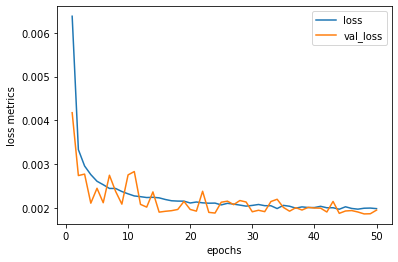

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


epochs = [i+1 for i in range(50)]
loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

plt.plot(epochs, loss_gru)
plt.plot(epochs, val_loss_gru)
plt.xlabel("epochs")
plt.ylabel("loss metrics")
plt.legend(['loss', 'val_loss'])
plt.savefig("./images/loss_gru.jpg")

y_pred_gru = gru_model.predict(x_test)
y_real_pred_gru = scaler.inverse_transform(y_pred_gru)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_gru))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_gru, squared=False))

# Save model

In [56]:
gru_model.save('./model/rnn.h5')

# Load and use model

In [66]:
import keras

new_model = keras.models.load_model('./model/rnn.h5')
new = new_model.predict(x_test)
new

126/126 [==============================] - 1s 4ms/step


array([[0.10033071, 0.02974549, 0.07338479, 0.07468648],
       [0.10185571, 0.02265386, 0.06292497, 0.05639981],
       [0.11865223, 0.02413091, 0.0732044 , 0.05524476],
       ...,
       [0.23216617, 0.09914624, 0.17254412, 0.19404295],
       [0.21607238, 0.11282393, 0.1764462 , 0.17673017],
       [0.22856839, 0.10636438, 0.16234745, 0.18139666]], dtype=float32)